In [ ]:
import json
import numpy as np 

from matplotlib import pyplot as plt 
import seaborn as sns


In [34]:
from collections import defaultdict
import pdb
from pathlib import Path
import sys
sys.path.insert(0, "/home/t-eliass/miso_sm/")
from miso.data.dataset_readers.calflow_parsing.calflow_graph import CalFlowGraph


def get_vocab_idxs(checkpoint_dir, tokens):
    with open(Path(checkpoint_dir).joinpath("ckpt/vocabulary/target_tokens.txt")) as f1:
        tgt_tokens = [x.strip() for x in f1.readlines()]

    print(f"vocab size: {len(tgt_tokens)}")
    indices = [tgt_tokens.index(tok) for tok in tokens]
    return {tok:ind for tok, ind in zip(tokens, indices)}

def get_prefix_prob(probs, idx, tokens):
    total_log_prob = 0.0
    for i, tok in enumerate(tokens[0:idx]):
        log_prob_correct_token = np.log(probs[i][tok])
        total_log_prob += log_prob_correct_token
    return total_log_prob

def process_json(path, a_tok, b_tok, fxn_of_interest, prefix_of_interest = None):
    with open(path) as f1:
        data = json.load(f1)

    to_ret = defaultdict(list)
    for instance in data: 
        instance = instance
        target_toks = [x[0] for x in instance['next_token']]
        left_context = [x[0] for x in instance['left_context']][1:]
        if fxn_of_interest not in target_toks:
            continue
        if prefix_of_interest is not None:
            if left_context != prefix_of_interest:
                continue 

        probs = instance['prob_dist']

        idxs_of_interest = [i for i,x in enumerate(target_toks) if x == fxn_of_interest]
        for idx in idxs_of_interest:
            log_prob_prefix = get_prefix_prob(probs, idx, target_toks)
            
            log_prob_a = np.log(probs[idx][a_tok]) + log_prob_prefix
            log_prob_b = np.log(probs[idx][b_tok]) + log_prob_prefix
            prefix = left_context[0:idx]

            to_ret[" ".join(prefix)].append({a_tok:np.exp(log_prob_a), b_tok: np.exp(log_prob_b)})
    return to_ret 


def get_prefix_frequency(prefix, train_tgt_toks):
    freq = 0
    for seq in train_tgt_toks:

        seq = seq[2:]
        if seq[0:len(prefix)] == prefix:
            freq += 1
    return freq

def get_token_frequency(token, train_tgt_toks):
    freq = 0
    for seq in train_tgt_toks:
        if token in seq:
            freq += 1
    return freq

def get_train_toks(train_dir, fxn):
    train_dir = Path(train_dir)
    train_src = train_dir.joinpath("train.src_tok")
    train_tgt = train_dir.joinpath("train.tgt")

    with open(train_src)  as src_f, open(train_tgt) as tgt_f: 
        train_src_lines = src_f.readlines()
        train_tgt_lines = tgt_f.readlines() 
    tgt_seqs = []
    for src_line, tgt_line in zip(train_src_lines, train_tgt_lines): 
        graph = CalFlowGraph(src_line.strip(), tgt_line.strip(), use_program=False, use_agent_utterance=True, use_context = True, fxn_of_interest = fxn) 
        data = graph.get_list_data("@start@","@end@")
        tgt_tokens = data['tgt_tokens']
        tgt_seqs.append(tgt_tokens)
    return tgt_seqs

def get_total_prob(probs, shared_prefixes):
    prob_items = list(probs.items())
    random_val = prob_items[0][1][0]
    to_ret = {k: [] for k in random_val.keys()}
    for prefix, prob_dict_list in prob_items:
        # check prefix against data 
        if prefix.split(" ") not in shared_prefixes:
            continue

        for prob_dict in prob_dict_list:
            for k, p in prob_dict.items():
                to_ret[k].append(p)
    
    to_ret = {k : np.mean(v) for k,v in to_ret.items()}
    return to_ret 


def get_shared_prefixes(train_seqs, fxn1, fxn2): 
    fxn1_prefixes = []
    fxn2_prefixes = []
    for seq in train_seqs:
        if fxn1 in seq:
            fxn1_index = seq.index(fxn1)
            # for i in range(0, fxn1_index): 
            fxn1_prefixes.append(seq[1:fxn1_index])
        if fxn2 in seq:
            fxn2_index = seq.index(fxn2)
            # for i in range(0, fxn2_index): 
            fxn2_prefixes.append(seq[1:fxn2_index])

    shared_prefixes = [x for x in fxn1_prefixes if x in fxn2_prefixes]
    return shared_prefixes


In [ ]:

probs_no_add = process_json("/home/t-eliass/amlt_models/transformer_min_pair_generated_v100/FindManager_12_seed/5000_100//translate_output/test_valid_probs.json", "FindManager", "FindReports", "FindManager")

In [ ]:
probs_add = process_json("/home/t-eliass/amlt_models/transformer_min_pair_generated_v100/FindManager_12_seed/5000_100//translate_output/test_valid_probs.json", "FindManager", "FindReports", "FindManager", shared_prefix=True)

In [35]:
# data_dir = f"/home/t-eliass/resources/data/smcalflow_samples_curated/FindManager/max_100"
# all_train_tgt_toks = get_train_toks(data_dir,None)
# print("getting seqs")
# shared_prefixes = get_shared_prefixes(all_train_tgt_toks, "FindManager", "FindReports")
total_no_add = get_total_prob(probs_no_add, shared_prefixes)

# total_add = get_total_prob(probs_add)

print(total_no_add)
# print(total_add)

{'FindManager': 0.74402166042593, 'FindReports': 0.09096018403649085}


In [33]:

print(probs_no_add['@ROOT@ Yield'])


[{'FindManager': 0.9070095346839969, 'FindReports': 0.0017368206928593845}, {'FindManager': 0.03014991629722177, 'FindReports': 0.004193189885475206}, {'FindManager': 0.00035501523300738344, 'FindReports': 0.0005646409388658561}, {'FindManager': 0.9445018648219465, 'FindReports': 0.01565385860779355}, {'FindManager': 0.9453301031824849, 'FindReports': 0.006250443170996547}, {'FindManager': 0.9971066763508386, 'FindReports': 0.0002393387623898245}, {'FindManager': 0.9886131593840685, 'FindReports': 0.002190197695980583}, {'FindManager': 0.9929403903669975, 'FindReports': 0.0009532257435182266}, {'FindManager': 0.47196642327089827, 'FindReports': 0.24268142116882344}, {'FindManager': 0.9689927183870629, 'FindReports': 0.0011985624409724509}, {'FindManager': 0.9833293737050386, 'FindReports': 0.003041060112658836}, {'FindManager': 0.03785513213144863, 'FindReports': 0.8381233812811992}, {'FindManager': 0.9954019192836087, 'FindReports': 0.00089963466720711}, {'FindManager': 0.339203862672

# FindManager vs FindReports

## Questions:
1. Is $P_{model}(FindManager)$ correlated with $Freq(FindReports)$ 
2. Is $P_{model}(FindManager)$ correlated with $P_{data}(FindReports)$
3. Is $P_{model}(FindManager | prefix, input)$ correlated with $P_{data}(FindReports | prefix, input')$ where $input$ and $input'$ are similar 
  

In [38]:



all_probs = {}
all_freqs = {}
for split in [5000, 10000, 20000, 50000, 100000, "max"]:
    data_dir = f"/home/t-eliass/resources/data/smcalflow_samples_curated/FindManager/{split}_100"
    train_tgt_toks = get_train_toks(data_dir,"FindManager")
    fr_token_freq = get_token_frequency("FindReports", train_tgt_toks)
    fm_token_freq = 100
    all_freqs[f"{split}_100"] = (fm_token_freq, fr_token_freq)
    # for seed in [31, 64]: 
    #     probs = process_json(f"/home/t-eliass/amlt_models/transformer/FindManager_{seed}_seed/{split}_100//translate_output/test_valid_probs.json", "FindManager", "FindReports", "FindManager")
    #     all_probs[f"{split}_100_{seed}"] = probs

    

        

In [39]:
# with open('/home/t-eliass/scratch/FindManager_12,31,64_all_probs.json', "w") as f1:
#     json.dump(all_probs, f1)

with open('/home/t-eliass/scratch/FindManager_31,64_all_probs.json') as f1:
#      #json.dump(all_probs, f1)
    all_probs = json.load(f1)
    

In [40]:
# procedure: For each prefix type, try to aggregate FM and FR probs
# - log the prefixes that didn't work 


fr_counts = []
fr_freqs = []
fr_probs = []
fm_probs = []
data_sizes = [5000, 10000, 20000, 50000, 100000, 119141]


for i, split in enumerate([5000, 10000, 20000, 50000, 100000, "max"]):
    data_dir = f"/home/t-eliass/resources/data/smcalflow_samples_curated/FindManager/{split}_100"
    train_tgt_toks = get_train_toks(data_dir,"FindManager")
    shared_prefixes = get_shared_prefixes(train_tgt_toks, "FindManager", "FindReports")

    (fm_token_freq, fr_token_freq) = all_freqs[f"{split}_100"]
    for seed in [31, 64]: 
        total_probs = get_total_prob(all_probs[f"{split}_100_{seed}"], shared_prefixes)
        fr_counts.append(fr_token_freq)
        fr_freqs.append(fr_token_freq/data_sizes[i])
        fr_probs.append(total_probs["FindReports"])
        fm_probs.append(total_probs["FindManager"])


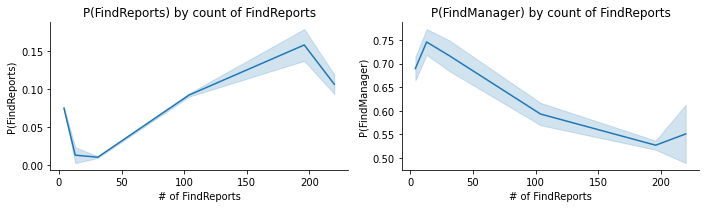

In [43]:

fig, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,3))
sns.lineplot(x=fr_counts, y=fr_probs, ax = ax[0])
sns.despine()
ax[0].set_ylabel("P(FindReports)")
ax[0].set_xlabel("# of FindReports")
ax[0].set_title("P(FindReports) by count of FindReports")

sns.lineplot(x=fr_counts, y=fm_probs, ax = ax[1])
sns.despine()
ax[1].set_ylabel("P(FindManager)")
ax[1].set_xlabel("# of FindReports")
ax[1].set_title("P(FindManager) by count of FindReports")

plt.tight_layout()
plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/FindManager_vs_FindReports_controlled_prefix.pdf")

In [ ]:



fig, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10,3))

sns.lineplot(x=fr_freqs, y=fr_probs, ax = ax[0])
sns.despine()
ax[0].set_ylabel("P(FindReports)")
ax[0].set_xlabel("Freq. of FindReports")
ax[0].set_title("P(FindReports) by frequency of FindReports")

sns.lineplot(x=fr_freqs, y=fm_probs, ax = ax[1])
sns.despine()
ax[1].set_ylabel("P(FindManager)")
ax[1].set_xlabel("Freq. of FindReports")
ax[1].set_title("P(FindManager) by frequency of FindReports")



# FindManager vs FindReports follow-up questions 
1. It looks like FindReports accounts for the drop in $P(FindManager)$ but not for the initial difference from 100%, i.e. mass is not always split between FindManager and FindReports. If FindReports isn't accounting for the gap between FindManager and 100, what is? 

# Full data correlation
In the full data, is there a correlation between $P_{model}(Function)$ and $P_{data}(Function)$? 




In [ ]:
from tqdm import tqdm 

def process_json(path, a_tok, b_tok, fxn_of_interest):
    with open(path) as f1:
        data = json.load(f1)

    to_ret = defaultdict(list)
    for instance in data: 
        instance = instance
        target_toks = [x[0] for x in instance['next_token']]
        left_context = [x[0] for x in instance['left_context']][1:]
        if fxn_of_interest not in target_toks:
            continue
        probs = instance['prob_dist']

        idxs_of_interest = [i for i,x in enumerate(target_toks) if x == fxn_of_interest]
        for idx in idxs_of_interest:
            prob_a = probs[idx][a_tok]
            prob_b = probs[idx][b_tok]
            prefix = left_context[0:idx]
            print(f"prefix: {prefix}")
            to_ret[" ".join(prefix)].append({a_tok: prob_a, b_tok: prob_b})
    return to_ret 


def get_correlation(split, path): 
    path = Path(path) 
    path_to_dict = path.joinpath(split, "translate_output", "test_valid_probs.json")
    print(f"opening data")
    with open(path_to_dict) as f1:
        data = json.load(f1)
    print(f"got data")
    freqs = {}
    counts = {}
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    for instance in tqdm(data): 
        instance = instance
        target_toks = [x[0] for x in instance['next_token']]
        left_context = [x[0] for x in instance['left_context']][1:]
        probs = instance['prob_dist']

        for idx in range( len(target_toks)):
            prob_dict = probs[idx]
            for func, prob in prob_dict.items():
                if func in ["@ROOT@", "@start@", "@end@"]:
                    continue
                probs_to_ret[func].append(prob)
                func_ontology.add(func)

    train_tgt_toks = get_train_toks(f"/home/t-eliass/resources/data/smcalflow_samples_curated/FindManager/{split}", "")
    for func in func_ontology:
        freq = get_token_frequency(func, train_tgt_toks)

        counts[func] = freq

    return counts, probs_to_ret




In [ ]:
all_counts = []
all_probs = []
all_freqs = []

data_sizes = [5000, 10000, 20000, 50000, 100000, 119141]
for seed in [31, 64]: 
    for i, split in enumerate([5000, 10000, 20000, 50000, 100000, "max"]): 
        print(f"split {split} seed: {seed}")
        data_size = data_sizes[i]
        counts, probs = get_correlation(f"{split}_100", f"/home/t-eliass/amlt_models/transformer/FindManager_{seed}_seed")

        functions = counts.keys()
        flat_counts = [counts[k] for k in functions]
        flat_freqs = [counts[k]/data_size for k in functions]
        flat_probs = [np.mean(probs[k]) for k in functions]
        all_counts += counts
        all_probs += flat_probs
        all_freqs += flat_freqs

In [ ]:



fig, ax = plt.subplots()
plt.scatter(x=all_freqs, y=all_probs)



In [ ]:
outlier = [func for func in functions if counts[func] == 5000]
outlier = [func for func in outlier if np.mean(probs[func]) < 0.01]
print(outlier)

# FindManager vs Fence

Previous analysis just compared overall model prob of FindManager and FindReports, but what about the probability given a particular input. I think that's 